# **IMPORT MODULES/FUNCTIONS**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

from kan import *
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
from functions import get_mean_pulse_from_set, momentos, gauss, gauss_fit, move_to_reference, create_and_delay_pulse_pair, pulso, pulso_escalon, pulso_sigmoid, create_position

In [3]:
V55= np.load('/home/josea/Co60_5cm_5cm.npy')
V28= np.load('/home/josea/Co60_2cm_8cm.npy')
V82= np.load('/home/josea/Co60_8cm_2cm.npy')

source = 'Co60'
path = '/home/josea/PracticaTimingDigital/pulso_' + source + '_filt_norm.npz'

data = np.load(path)
pulsos_practica_master = data['data']

# **INTERPOLATION**

In [4]:
#--------------------------------Interpolar pulsos reales---------------------------------
input = V28
EXTRASAMPLING = 8
Nt = np.shape(input)[1]
Nt_new = Nt *  EXTRASAMPLING
time_step = 0.2
new_time_step = time_step / EXTRASAMPLING

tiempo = np.linspace(0, Nt, Nt)
tiempo_new = np.linspace(0,Nt,Nt_new)

interp_func_V28 = interp1d(tiempo, V28, kind = 'cubic', axis=1)
new_V28 = interp_func_V28(tiempo_new)

interp_func_V55 = interp1d(tiempo, V55, kind = 'cubic', axis=1)
new_V55 = interp_func_V55(tiempo_new)

interp_func_V82 = interp1d(tiempo, V82, kind = 'cubic', axis=1)
new_V82 = interp_func_V82(tiempo_new)

REALS = np.concatenate((new_V28, new_V55, new_V82), axis = 0)

interp_func_practica = interp1d(tiempo,pulsos_practica_master, kind = 'cubic', axis = 1)
new_pulsos_practica = interp_func_practica(tiempo_new)

#---------------------------------------------------------------- Align the pulses -----------------------------------
align_steps = 20
new_pulsos_practica[:,:,1] = np.roll(new_pulsos_practica[:,:,1], align_steps)
new_pulsos_practica[:,:align_steps,1] = np.random.normal(scale = 1e-3, size = align_steps)

print('Number of time points: %.d' % (Nt))
print('Time step: %.2f' % (time_step))
print('New number of time points: %.d' % (Nt_new))
print('New time step: %.4f' % (new_time_step))

Number of time points: 600
Time step: 0.20
New number of time points: 4800
New time step: 0.0250


# **GENERATE MEAN PULSE PER DETECTOR**

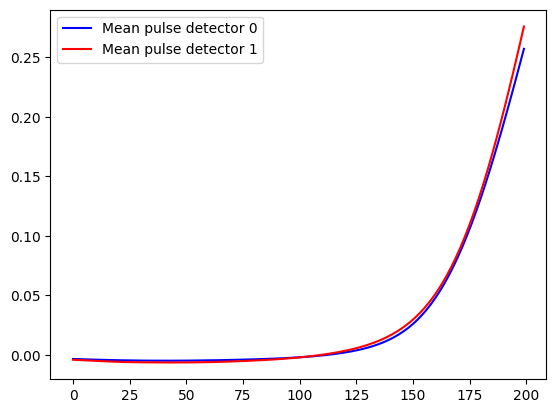

In [5]:
mean_pulse_dec0 = get_mean_pulse_from_set(new_pulsos_practica, channel = 0)
mean_pulse_dec1 = get_mean_pulse_from_set(new_pulsos_practica, channel = 1)

#-------------------------------------- Plot cropped mean pulses -----------------------------
start = 50*EXTRASAMPLING
stop = 75*EXTRASAMPLING


plt.plot(mean_pulse_dec0[start:stop], 'b-', label = 'Mean pulse detector 0')
plt.plot(mean_pulse_dec1[start:stop], 'r-', label = 'Mean pulse detector 1')
plt.legend()

# **DETECTORS**

In [6]:
#------------------------------------ Important definitions ------------------------------------
ajuste_grueso = 1 # 0 = YES, 1 = NO
delay_steps = 20
moments_order = 1
Num_casos = 2000
Nc = 2

t_shift = 8 #In time steps
t = np.linspace(0, Nt, Nt_new)
t0 = 65 + np.random.randint(10, size = Num_casos)
#t0 = 550 + np.random.randint(100, size = Num_casos)


# Define size of train set from datos practica
Ntrain_practica = int(1*new_pulsos_practica.shape[0])
Ntest_practica = int(0.0*new_pulsos_practica.shape[0])
print('Número de casos de entrenamiento de la práctica: ', Ntrain_practica)
print('Número de casos de Test de la práctica: ', Ntest_practica)

Número de casos de entrenamiento de la práctica:  2211
Número de casos de Test de la práctica:  0


In [7]:
# Detector 0 definitions 
tau_rise_dec0 = 20
tau_drop_dec0 = 150
Photon_yield = 100
center_window_dec0 = 0.3
rise_window_dec0 = 0.3

# Detector 1 definitions 
tau_rise_dec1 = 20
tau_drop_dec1 = 150
Photon_yield = 100
center_window_dec1 = 0.3
rise_window_dec1 = 0.3

In [8]:
#------------------------------ Create simulated pulses ---------------------------------
INPUT_dec0 = np.zeros((Num_casos, Nt_new))
INPUT_dec1 = np.zeros((Num_casos, Nt_new))

for i in range(Num_casos):
  #PULSO_dec0 = pulso_escalon(t, t0[i], A = 0.6)
  #PULSO_dec1 = pulso_escalon(t, t0[i], A = 0.6)
  PULSO_dec0 = pulso(t, t0[i], tau_rise = tau_rise_dec0, tau_drop = tau_drop_dec0)
  PULSO_dec1 = pulso(t, t0[i], tau_rise = tau_rise_dec1, tau_drop = tau_drop_dec1)
  INPUT_dec0[i,:] = PULSO_dec0
  INPUT_dec1[i,:] = PULSO_dec1

Text(0.5, 1.0, 'Detector 1')

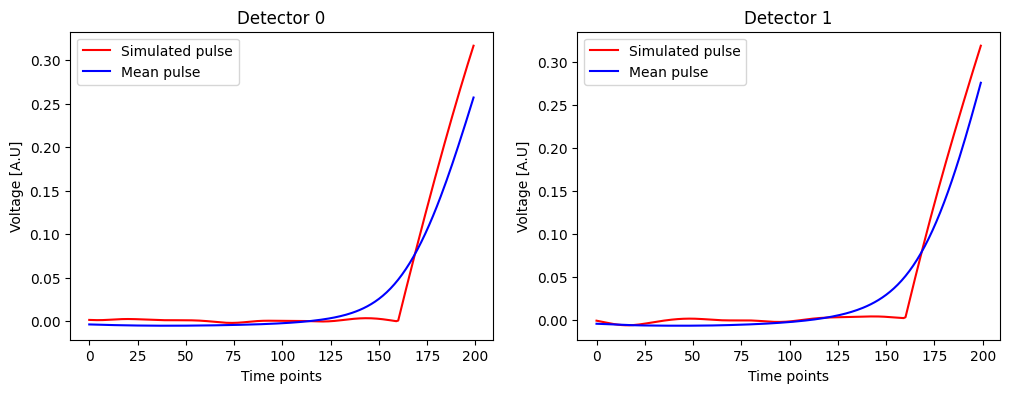

In [9]:
#pulso_original_dec0 = pulso_escalon(t, 550, A = 0.6)
#pulso_original_dec1 = pulso_escalon(t, 550, A = 0.6)
#pulso_original_dec0 =  pulso_sigmoid(tiempo_new, 80, A = Photon_yield, center_window = center_window_dec0, rise_window = rise_window_dec0, tau_rise = tau_rise_dec0, tau_drop = tau_drop_dec0, NOISE = False)
#pulso_original_dec1 =  pulso_sigmoid(tiempo_new, 80, A = Photon_yield, center_window = center_window_dec1, rise_window = rise_window_dec1, tau_rise = tau_rise_dec1, tau_drop = tau_drop_dec1, NOISE = False)
pulso_original_dec0 = pulso(t, 70, tau_rise = tau_rise_dec0, tau_drop = tau_drop_dec0)
pulso_original_dec1 = pulso(t, 70, tau_rise = tau_rise_dec1, tau_drop = tau_drop_dec1)



plt.figure(figsize = (12,4))
plt.subplot(121)
plt.plot(pulso_original_dec0[start:stop],'r-', label = 'Simulated pulse')
plt.plot(mean_pulse_dec0[start:stop],'b-', label = 'Mean pulse')
plt.legend()
plt.xlabel('Time points')
plt.ylabel('Voltage [A.U]')
plt.title('Detector 0')

plt.subplot(122)
plt.plot(pulso_original_dec1[start:stop],'r-', label = 'Simulated pulse')
plt.plot(mean_pulse_dec1[start:stop],'b-', label = 'Mean pulse')
plt.legend()
plt.xlabel('Time points')
plt.ylabel('Voltage [A.U]')
plt.title('Detector 1')

In [10]:
if ajuste_grueso == 0:
    
    #-------------------------------- Move simulated pulses  to align with mean and delay--------------------------------------------
    if Num_casos != 0:
        delays_dec0, moved_pulses_dec0 = move_to_reference(mean_pulse_dec0, np.expand_dims(INPUT_dec0, axis = -1), start = start, stop = stop, max_delay = int(stop-start), channel = 0)
        delays_dec1, moved_pulses_dec1 = move_to_reference(mean_pulse_dec1, np.expand_dims(INPUT_dec1, axis = -1), start = start, stop = stop, max_delay = int(stop-start), channel = 0)
    

        INPUT_dec0, REF_dec0 = create_and_delay_pulse_pair(moved_pulses_dec0, new_time_step, delay_steps = delay_steps, NOISE = True)
        INPUT_dec1, REF_dec1 = create_and_delay_pulse_pair(moved_pulses_dec1, new_time_step, delay_steps = delay_steps, NOISE = True)
    
    if Num_casos == 0:
        INPUT_dec0 = np.zeros((Num_casos, int(stop-start), 2))
        INPUT_dec1 = np.zeros((Num_casos, int(stop-start), 2))
        REF_dec0 = np.zeros((Num_casos,))
        REF_dec1 = np.zeros((Num_casos,))
    
    #--------------------------------- Move rest of the pulses to align with mean and then delay them ---------------------------------------
    delays2_dec0, moved_pulses2_dec0 = move_to_reference(mean_pulse_dec0, new_pulsos_practica[:Ntrain_practica,:,:], start = start, stop = stop, max_delay = int(stop-start), channel = 0)
    delays2_dec1, moved_pulses2_dec1 = move_to_reference(mean_pulse_dec1, new_pulsos_practica[:Ntrain_practica,:,:], start = start, stop = stop, max_delay = int(stop-start), channel = 1)
    INPUT2_dec0, REF2_dec0 = create_and_delay_pulse_pair(moved_pulses2_dec0, new_time_step, delay_steps = delay_steps, NOISE = True)
    INPUT2_dec1, REF2_dec1 = create_and_delay_pulse_pair(moved_pulses2_dec1, new_time_step, delay_steps = delay_steps, NOISE = True)


if ajuste_grueso == 1:

    INPUT_dec0, REF_dec0 = create_and_delay_pulse_pair(INPUT_dec0[:,start:stop], new_time_step, delay_steps = delay_steps, NOISE = True)
    INPUT_dec1, REF_dec1 = create_and_delay_pulse_pair(INPUT_dec1[:,start:stop], new_time_step, delay_steps = delay_steps, NOISE = True)


    INPUT2_dec0, REF2_dec0 = create_and_delay_pulse_pair(new_pulsos_practica[:Ntrain_practica,start:stop,0], new_time_step, delay_steps = delay_steps, NOISE = True)
    INPUT2_dec1, REF2_dec1 = create_and_delay_pulse_pair(new_pulsos_practica[:Ntrain_practica,start:stop,1], new_time_step, delay_steps = delay_steps, NOISE = True)


#--------------------------------- Create train set ----------------------------------------------------
trainX_dec0 = np.concatenate((INPUT_dec0, INPUT2_dec0), axis = 0)
trainX_dec1 = np.concatenate((INPUT_dec1, INPUT2_dec1), axis = 0)

REF_train_dec0 = np.concatenate((REF_dec0, REF2_dec0))
REF_train_dec1 = np.concatenate((REF_dec1, REF2_dec1))

Text(0.5, 1.0, 'Detector 1')

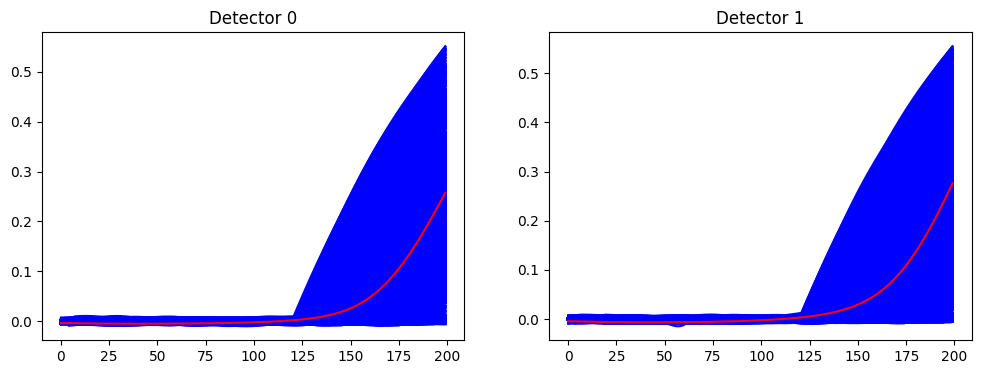

In [11]:
plt.figure(figsize = (12,4))

plt.subplot(121)
for i in range(trainX_dec0.shape[0]):
    plt.plot(trainX_dec0[i,:,0],'b-')
plt.plot(mean_pulse_dec0[start:stop],'r-')
plt.title('Detector 0')

plt.subplot(122)
for i in range(trainX_dec1.shape[0]):
    plt.plot(trainX_dec1[i,:,0],'b-')
plt.plot(mean_pulse_dec1[start:stop],'r-')
plt.title('Detector 1')

In [12]:
#-------------------------------------------------------------- Calculate moments ---------------------------------------------------
M_Train_dec0 = momentos(trainX_dec0, order = moments_order)
M_Train_dec1 = momentos(trainX_dec1, order = moments_order)

#-------------------------------------------------------------- Normalize ---------------------------------------------------
min_dec0 = np.min(M_Train_dec0)
max_dec0 = np.max(M_Train_dec0)

min_dec1 = np.min(M_Train_dec1)
max_dec1 = np.max(M_Train_dec1)

M_Train_dec0 = (M_Train_dec0 - min_dec0)/(max_dec0 - min_dec0)
M_Train_dec1 = (M_Train_dec1 - min_dec1)/(max_dec1 - min_dec1)


#-------------------------------------------------------------- Print information ---------------------------------------------------
NM = np.shape(M_Train_dec0)[1]
print(M_Train_dec0.shape, "NM =", NM)
print("Min detector 0:", min_dec0)
print("Max detector 0:", max_dec0)

NM = np.shape(M_Train_dec1)[1]
print(M_Train_dec1.shape, "NM =", NM)
print("Min detector 1:", min_dec1)
print("Max detector 1:", max_dec1)

(4211, 3, 2) NM = 3
Min detector 0: -0.5888511732968983
Max detector 0: 24.542180826971368
(4211, 3, 2) NM = 3
Min detector 1: -0.4749554148005084
Max detector 1: 25.013969668734667


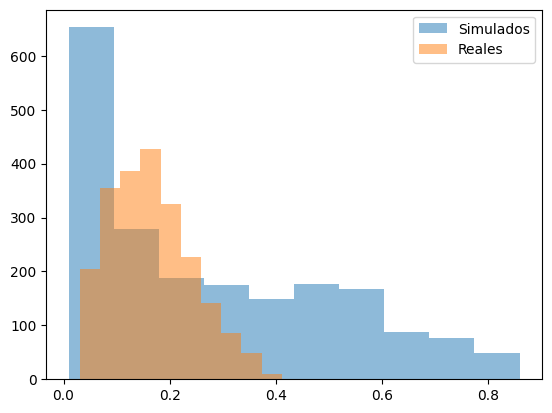

In [13]:
plt.hist(M_Train_dec0[:Num_casos,0,0], alpha = 0.5, label = 'Simulados');
plt.hist(M_Train_dec0[Num_casos:,0,0], alpha = 0.5, label = 'Reales');
plt.legend()

# **FULL TOF (KAN)**

In [14]:
#-------------------------------- Create test set ---------------------------------------------------------
if ajuste_grueso == 0:
    delays_test_dec0, moved_pulses_test_dec0 = move_to_reference(mean_pulse_dec0, new_V55, start = start, stop = stop, max_delay = int(stop-start), channel = 0)
    delays_test_dec1, moved_pulses_test_dec1 = move_to_reference(mean_pulse_dec1, new_V55, start = start, stop = stop, max_delay = int(stop-start), channel = 1)
    
    # Create other positions 
    new_V55 = np.stack((moved_pulses_test_dec0, moved_pulses_test_dec1), axis = 2)
    new_V28 = create_position(new_V55, channel_to_move = 1, channel_to_fix = 0, t_shift = t_shift, NOISE = True)
    new_V82 = create_position(new_V55, channel_to_move = 0, channel_to_fix = 1, t_shift = t_shift, NOISE = True)
    

if ajuste_grueso == 1:
    new_V55 = new_V55[:,start:stop,:]
    new_V28 = new_V28[:,start:stop,:]
    new_V82 = new_V82[:,start:stop,:]



M_V55 = momentos(new_V55, order = moments_order)
M_V55[:,:,0] = (M_V55[:,:,0] - min_dec0)/(max_dec0 - min_dec0)
M_V55[:,:,1] = (M_V55[:,:,1] - min_dec1)/(max_dec1 - min_dec1)

M_V28 = momentos(new_V28, order = moments_order)
M_V28[:,:,0] = (M_V28[:,:,0] - min_dec0)/(max_dec0 - min_dec0)
M_V28[:,:,1] = (M_V28[:,:,1] - min_dec1)/(max_dec1 - min_dec1)

M_V82 = momentos(new_V82, order = moments_order)
M_V82[:,:,0] = (M_V82[:,:,0] - min_dec0)/(max_dec0 - min_dec0)
M_V82[:,:,1] = (M_V82[:,:,1] - min_dec1)/(max_dec1 - min_dec1)

MOMENTS_TEST = np.concatenate((M_V28, M_V55, M_V82), axis = 0)

In [25]:
model_dec0 = KAN(width = [3, 3, 1, 1], grid = 5, k = 3, seed = 0)
model_dec1 = KAN(width = [3, 3, 1, 1], grid = 5, k = 3, seed = 0)

In [26]:
# Create Dataset
train_dataset_dec0 = torch.utils.data.TensorDataset(torch.from_numpy(M_Train_dec0), torch.from_numpy(np.expand_dims(REF_train_dec0, axis = -1)))
train_dataset_dec1 = torch.utils.data.TensorDataset(torch.from_numpy(M_Train_dec1), torch.from_numpy(np.expand_dims(REF_train_dec1, axis = -1)))

# Create DataLoaders
train_loader_dec0 = torch.utils.data.DataLoader(train_dataset_dec0, batch_size = 32, shuffle = True)
train_loader_dec1 = torch.utils.data.DataLoader(train_dataset_dec1, batch_size = 32, shuffle = True)

optimizer_dec0 = torch.optim.AdamW(model_dec0.parameters(), lr = 5e-5) #Regularization?
optimizer_dec1 = torch.optim.AdamW(model_dec1.parameters(), lr = 5e-5)

In [27]:
def train_loop_KAN(model, optimizer, train_loader, test_tensor, EPOCHS = 75):
    
    epoch_number = 0
    loss_list = []
    test = []

    for epoch in range(EPOCHS):

        running_loss = 0.
        avg_loss_epoch = 0.
    
        for i, data in enumerate(train_loader):
            
            # Every data instance is an input + label pair
            inputs, labels = data
        
            # Zero your gradients for every batch!
            optimizer.zero_grad()
        
            # Make predictions for this batch
            outputs_0 = model(inputs[:,:,0])
            outputs_1 = model(inputs[:,:,1])

            # Compute the loss and its gradients
            loss = torch.mean((outputs_0 - outputs_1 - labels)**2) + torch.sum(torch.relu(-outputs_0)) + torch.sum(torch.relu(-outputs_1))
            loss.backward()
        
            # Adjust learning weights
            optimizer.step()
        
            # Gather data and report
            running_loss += loss.item()

    
        avg_loss_epoch = running_loss / int(i) # loss per batch        
        loss_list.append(avg_loss_epoch)
        
        print('EPOCH {}:'.format(epoch_number + 1))
        print('LOSS train {}'.format(avg_loss_epoch))
        
        # Calculate predictions
        test_epoch = model(test_tensor)
        test.append(np.squeeze(test_epoch.detach().numpy()))

        epoch_number += 1

    # Turn array to list
    loss_array = np.array(loss_list, dtype = 'object')
    test = np.array(test, dtype = 'object')

    return loss_array, test

In [32]:
loss_dec0, test_dec0 = train_loop_KAN(model_dec0, optimizer_dec0, train_loader_dec0, torch.tensor(MOMENTS_TEST[:,:,0]), EPOCHS = 200)
loss_dec1, test_dec1 = train_loop_KAN(model_dec1, optimizer_dec1, train_loader_dec1, torch.tensor(MOMENTS_TEST[:,:,1]), EPOCHS = 200)

EPOCH 1:
LOSS train 0.006981184534625272
EPOCH 2:
LOSS train 0.0067110880576799125
EPOCH 3:
LOSS train 0.0064037362877590615
EPOCH 4:
LOSS train 0.00612298898147023
EPOCH 5:
LOSS train 0.005886896237877351
EPOCH 6:
LOSS train 0.00561973429456917
EPOCH 7:
LOSS train 0.00540377504846896
EPOCH 8:
LOSS train 0.005151589735383223
EPOCH 9:
LOSS train 0.004975693142387251
EPOCH 10:
LOSS train 0.004793031069466875
EPOCH 11:
LOSS train 0.0046655984454438216
EPOCH 12:
LOSS train 0.004514760591415256
EPOCH 13:
LOSS train 0.004392899974767037
EPOCH 14:
LOSS train 0.00430584410444749
EPOCH 15:
LOSS train 0.004209234117921675
EPOCH 16:
LOSS train 0.004107037555183411
EPOCH 17:
LOSS train 0.004059357552013325
EPOCH 18:
LOSS train 0.003976147062654671
EPOCH 19:
LOSS train 0.0039187260989152865
EPOCH 20:
LOSS train 0.003886185059611969
EPOCH 21:
LOSS train 0.003822830203798925
EPOCH 22:
LOSS train 0.0037773826425247805
EPOCH 23:
LOSS train 0.0037316110410179158
EPOCH 24:
LOSS train 0.003686669548984561

(array([5]),) 0.06366543250386199


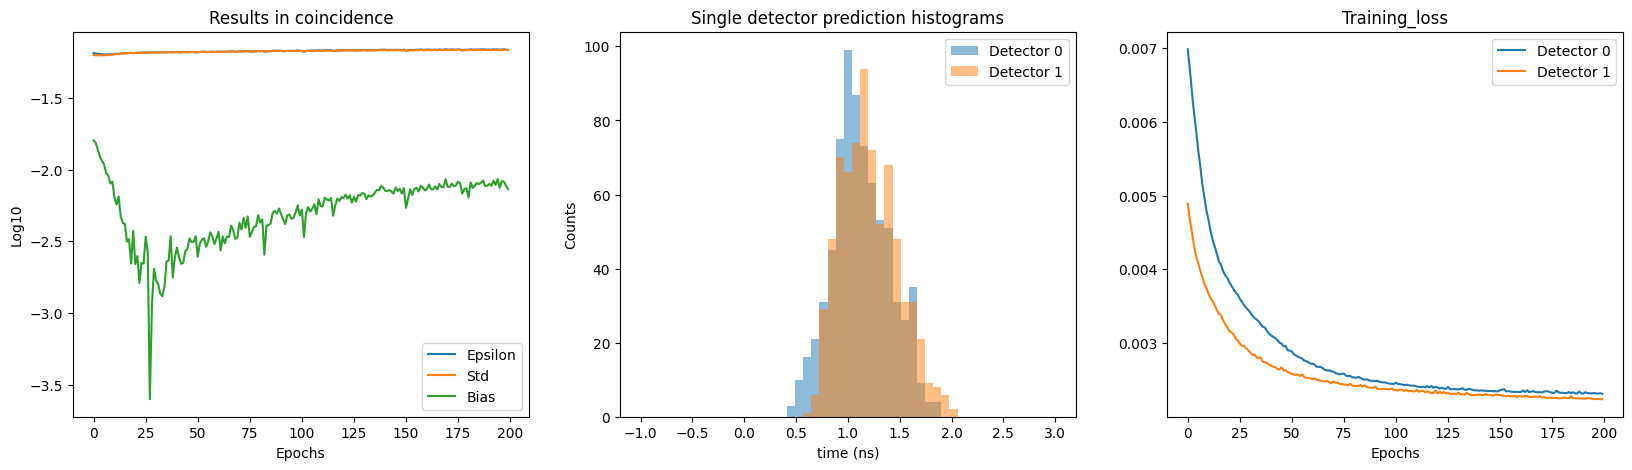

In [34]:
if ajuste_grueso == 0:
    TOFN_V28 = (test_dec0[:,:M_V28.shape[0]] - new_time_step*delays_test_dec0) - (test_dec1[:,:M_V28.shape[0]] - new_time_step*delays_test_dec1)
    TOFN_V55 = (test_dec0[:,M_V28.shape[0] :M_V28.shape[0] + M_V55.shape[0]] - new_time_step*delays_test_dec0) - (test_dec1[:,M_V28.shape[0] :M_V28.shape[0] + M_V55.shape[0]] - new_time_step*delays_test_dec1)
    TOFN_V82 = (test_dec0[:,M_V28.shape[0] + M_V55.shape[0]:] - new_time_step*delays_test_dec0) - (test_dec1[:,M_V28.shape[0] + M_V55.shape[0]:] - new_time_step*delays_test_dec1)

if ajuste_grueso == 1:

    TOFN_V28 = test_dec0[:,:M_V28.shape[0]] - test_dec1[:,:M_V28.shape[0]]
    TOFN_V55 = test_dec0[:,M_V28.shape[0] :M_V28.shape[0] + M_V55.shape[0]] - test_dec1[:,M_V28.shape[0] :M_V28.shape[0] + M_V55.shape[0]]
    TOFN_V82 = test_dec0[:,M_V28.shape[0] + M_V55.shape[0]:] - test_dec1[:,M_V28.shape[0] + M_V55.shape[0]:]

# Must turn to float64 in order to calculate std on a specific axis
TOFN_V28 = np.array(TOFN_V28, dtype = 'float64') 
TOFN_V55 = np.array(TOFN_V55, dtype = 'float64')
TOFN_V82 = np.array(TOFN_V82, dtype = 'float64') 

# Calculate 'centroids'
centroid_V28 = np.mean(TOFN_V28, axis = 1) - np.mean(TOFN_V55, axis = 1)
centroid_V82 = np.mean(TOFN_V82, axis = 1) - np.mean(TOFN_V55, axis = 1)

# Get errors to calculate Epsilon
mean_error_centroid = (abs(centroid_V28 + 0.2) + abs(centroid_V82 - 0.2)) / 2
mean_std = (np.std(TOFN_V82, axis = 1) + np.std(TOFN_V55, axis = 1) + np.std(TOFN_V28, axis = 1)) / 3
epsilon = (mean_error_centroid**2 + mean_std**2)**(1/2)
epsilon = np.array(epsilon, dtype = 'float64')
#ind_of_min_epsilon
print(np.where(epsilon == np.min(epsilon)), np.min(epsilon))


# PLot
plt.figure(figsize = (20,5))
plt.subplot(131)
plt.plot(np.log10(epsilon), label = 'Epsilon')
plt.plot(np.log10(mean_std), label = 'Std')
plt.plot(np.log10(mean_error_centroid), label = 'Bias')
plt.title('Results in coincidence')
plt.xlabel('Epochs')
plt.ylabel('Log10')
plt.legend()

plt.subplot(132)
if ajuste_grueso == 0:
    plt.hist(test_dec0[-1, M_V28.shape[0] : M_V28.shape[0] + M_V55.shape[0]] - new_time_step*delays_test_dec0, bins = 51, range = [-1, 3], alpha = 0.5, label = 'Detector 0');
    plt.hist(test_dec1[-1, M_V28.shape[0] : M_V28.shape[0] + M_V55.shape[0]] - new_time_step*delays_test_dec1, bins = 51, range = [-1, 3], alpha = 0.5, label = 'Detector 1');

if ajuste_grueso == 1:
    plt.hist(test_dec0[-1, :], bins = 51, range = [-1, 3], alpha = 0.5, label = 'Detector 0');
    plt.hist(test_dec1[-1, :], bins = 51, range = [-1, 3], alpha = 0.5, label = 'Detector 1');
plt.title('Single detector prediction histograms')
plt.xlabel('time (ns)')
plt.ylabel('Counts')
plt.legend()

plt.subplot(133)
plt.plot(loss_dec0[:], label = 'Detector 0')
plt.plot(loss_dec1[:], label = 'Detector 1')
plt.title('Training_loss')
plt.xlabel('Epochs')
plt.legend()




V82: CENTROID(ns) = 0.186  FWHM(ns) = 0.143  std(ns) = 0.061
V55: CENTROID(ns) = 0.008  FWHM(ns) = 0.144  std(ns) = 0.061
V28: CENTROID(ns) = -0.188  FWHM(ns) = 0.156  std(ns) = 0.066


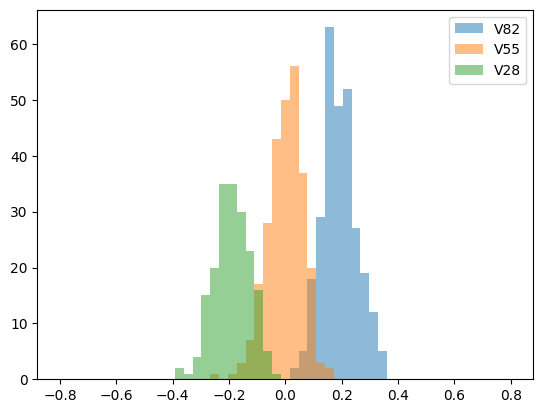

In [35]:
epoch = 5
nbins = 51
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
histogN_V82, binsN, patchesN  = plt.hist(TOFN_V82[epoch,:] - np.mean(TOFN_V55[epoch,:]), bins = nbins, range = [-0.8,0.8], alpha = 0.5, label = 'V82');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V82, sigmaN_V82 = gauss_fit(cbinsN, histogN_V82)

histogN_V55, binsN, patchesN  = plt.hist(TOFN_V55[epoch,:] - np.mean(TOFN_V55[epoch,:]), bins = nbins, range = [-0.8,0.8], alpha = 0.5, label = 'V55');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V55, sigmaN_V55 = gauss_fit(cbinsN, histogN_V55)

histogN_V28, binsN, patchesN  = plt.hist(TOFN_V28[epoch,:] - np.mean(TOFN_V55[epoch,:]), bins = nbins, range = [-0.8,0.8], alpha = 0.5, label = 'V28');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V28, sigmaN_V28 = gauss_fit(cbinsN, histogN_V28)
plt.legend()


FWHMN_V82 = 2.35482 * sigmaN_V82
FWHMN_V55 = 2.35482 * sigmaN_V55
FWHMN_V28 = 2.35482 * sigmaN_V28


print('')
print("V82: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V82, FWHMN_V82, sigmaN_V82))
print("V55: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V55, FWHMN_V55, sigmaN_V55))
print("V28: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V28, FWHMN_V28, sigmaN_V28))